# 安装依赖

- https://github.com/milesial/Pytorch-UNet/tree/master
- https://github.com/njcronin/DL_Track
- https://github.com/njcronin/DL_Track/blob/master/Labelling_Instructions.pdf

In [1]:
!pip install scipy scikit-image torch torchvision pathlib wandb segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Preparing metadata (setup.py) ... - done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=32a1db2078343fc24dc935c2121ab8ba5d0a2487ad036567559496706d8567c3
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60966 sha256=a831bfecc4159824f9a807ebeef5207b6e00789d0d76d312b862eb4f3458f279
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels


# 引用依赖包

In [2]:
%config Completer.use_jedi = False

In [3]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.nn.functional import relu, pad
from torch.utils.data import Dataset, DataLoader, random_split

from PIL import Image
from typing import Tuple
from pathlib import Path

import torch
from torch import nn, Tensor
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm
import wandb
import logging

# 设置wandb账号¶

In [4]:
os.environ['WANDB_API_KEY']='d561f1229ba7c4e207ca34042f29a43552a7447e'
!wandb login

wandb: Currently logged in as: torwayland (cupes-wangtao). Use `wandb login --relogin` to force relogin


# ScConv¶

In [5]:
class GroupNorm2d(nn.Module):

    def __init__(self, n_groups: int = 16, n_channels: int = 16, eps: float = 1e-10):
        super(GroupNorm2d, self).__init__()  
        print("n_channels: ", n_channels, "n_groups: ", n_groups)
        assert n_channels % n_groups == 0 
        self.n_groups = n_groups  
        self.gamma = nn.Parameter(torch.randn(n_channels, 1, 1))  # learnable gamma
        self.beta = nn.Parameter(torch.zeros(n_channels, 1, 1))  # learnable beta
        self.eps = eps 

    def forward(self, x):
        N, C, H, W = x.size()
        x = x.reshape(N, self.n_groups, -1) 
        mean = x.mean(dim=2, keepdim=True)  
        std = x.std(dim=2, keepdim=True)
        x = (x - mean) / (std + self.eps) 
        x = x.reshape(N, C, H, W)  
        return x * self.gamma + self.beta  


# Spatial and Reconstruct Unit
class SRU(nn.Module):

    def __init__(
            self,
            n_channels: int,  # in_channels
            n_groups: int = 16,  # 16
            gate_treshold: float = 0.5,  # 0.5,
            torch_gn:bool = True
    ):
        super().__init__()  

        # initialize GroupNorm2d
        self.gn = nn.GroupNorm( num_channels = n_channels, num_groups = n_groups ) if torch_gn else GroupNorm2d(n_channels = n_channels, n_groups = n_groups)
        # self.gn = GroupNorm2d(n_groups=n_groups, n_channels=n_channels)
        self.gate_treshold = gate_treshold  
        self.sigomid = nn.Sigmoid()  

    def forward(self, x):
        gn_x = self.gn(x) 
        w_gamma = self.gn.gamma / sum(self.gn.gamma)  # cal gamma weight
        reweights = self.sigomid(gn_x * w_gamma)  # importance

        info_mask = reweights >= self.gate_treshold
        noninfo_mask = reweights < self.gate_treshold
        x_1 = info_mask * x  
        x_2 = noninfo_mask * x  
        x = self.reconstruct(x_1, x_2) 
        return x

    def reconstruct(self, x_1, x_2):
        x_11, x_12 = torch.split(x_1, x_1.size(1) // 2, dim=1)
        x_21, x_22 = torch.split(x_2, x_2.size(1) // 2, dim=1)
        return torch.cat([x_11 + x_22, x_12 + x_21], dim=1)


# Channel Reduction Unit
class CRU(nn.Module):

    def __init__(self, in_channels: int, out_channels: int, kernel_size: int = 3, alpha: float = 1 / 2, squeeze_radio: int = 2, groups: int = 2):
        super().__init__()

        self.up_channel = up_channel = int(alpha * in_channels)
        self.low_channel = low_channel = in_channels - up_channel
        self.squeeze1 = nn.Conv2d(up_channel, up_channel // squeeze_radio, kernel_size=1, bias=False)
        self.squeeze2 = nn.Conv2d(low_channel, low_channel // squeeze_radio, kernel_size=1, bias=False)

        in_ch = up_channel // squeeze_radio
        out_ch = out_channels
        print("out_channels:", out_channels, "squeeze_radio: ", squeeze_radio, "up_channel: ",up_channel,"in_ch (out_channels // squeeze_radio): ", in_ch, "out_ch(out_channels):", out_ch)
        
        
        if in_ch >= 16:
            groups = 16
    
        self.GWC = nn.Conv2d(in_ch, out_channels, kernel_size=kernel_size, stride=1, padding=kernel_size // 2, groups=groups) 
        self.PWC1 = nn.Conv2d(in_ch, out_channels, kernel_size=1, bias=False)

        print("in_channels: ", in_channels, "out_channels: ", out_channels)
        print("up_channel: ", self.up_channel, "low_channel: ", self.low_channel)
        in_ch = low_channel // squeeze_radio
        out_ch = out_channels - low_channel // squeeze_radio
        print("out_channels:", out_channels, "squeeze_radio: ", squeeze_radio, "low_channel: ",low_channel,"in_ch (low_channel // squeeze_radio): ", in_ch, "out_ch(out_channels - low_channel // squeeze_radio):", out_ch)
        self.PWC2 = nn.Conv2d(in_ch, out_ch, kernel_size=1, bias=False) 
        #print("self.PWC2.weight.shape: ",self.PWC2.weight.shape)
        self.pool = nn.AdaptiveAvgPool2d(1)  
        
    def forward(self, x):

        up, low = torch.split(x, [self.up_channel, self.low_channel], dim=1)
        up, low = self.squeeze1(up), self.squeeze2(low)

        y1 = self.GWC(up) + self.PWC1(up)
        
        #print("low: ",low.shape)
        pwc2 = self.PWC2(low)
        #print("pwc2", pwc2.shape)
        y2 = torch.cat([pwc2, low], dim=1)

        s1 = self.pool(y1)
        s2 = self.pool(y2)
        s = torch.cat([s1, s2], dim=1)
        beta = F.softmax(s, dim=1)
        beta1, beta2 = torch.split(beta, beta.size(1) // 2, dim=1)
        y = beta1 * y1 + beta2 * y2
        return y


# Squeeze and Channel Reduction Convolution
class ScConv(nn.Module):

    def __init__(self, in_channels: int, out_channels: int, kernel_size: int = 3, stride: int = 1, padding: int = 1, n_groups: int = 2, gate_treshold: float = 0.5, alpha: float = 1 / 2, squeeze_radio: int = 2, groups: int = 2):
        super().__init__()

        self.SRU = SRU(in_channels, n_groups=n_groups, gate_treshold=gate_treshold, torch_gn=False) 
        self.CRU = CRU(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, alpha=alpha, squeeze_radio=squeeze_radio, groups=groups)

    def forward(self, x):
        x = self.SRU(x)  
        x = self.CRU(x) 
        return x

## U-Net 网络

In [6]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, kernel_size=3):
        super(DoubleConv,self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class ScDoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, kernel_size=3):
        super(ScDoubleConv,self).__init__()
        self.double_conv = nn.Sequential(
            ScConv(in_channels, out_channels, kernel_size=kernel_size, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            ScConv(out_channels, out_channels, kernel_size=kernel_size, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        print("in_channels: ", in_channels, "out_channels: ", out_channels)

    def forward(self, x):
        return self.double_conv(x)
    



class Down(nn.Module):
    """   """

    def __init__(self, in_channels, out_channels, kernel_size=3, dropout = 0.1):
        super(Down, self).__init__()
        self.double_conv = DoubleConv( in_channels, out_channels, kernel_size)
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Dropout2d(p=dropout),
        )

    def forward(self, x):
        skip_out = self.double_conv(x)
        down_output = self.maxpool_conv(skip_out)
        return (down_output, skip_out)
    
    
    
class ScDown(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels, kernel_size=3, dropout = 0.1):
        super(ScDown, self).__init__()
        self.double_conv = ScDoubleConv(in_channels, out_channels, kernel_size)
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Dropout2d(p=dropout),
        )

    def forward(self, x):
        skip_out = self.double_conv(x)
        down_output = self.maxpool_conv(skip_out)
        return (down_output, skip_out)


    
class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, kernel_size = 2, dropout = 0.1, stride = 2):
        super().__init__()
        
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size = kernel_size, stride = stride)
        
        self.conv = nn.Sequential(
            nn.Dropout2d(p=dropout),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x1, x2):
        x = self.up(x1)
        x = torch.cat([x, x2], dim = 1)
        return self.conv(x)
    

class ScUp(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, kernel_size = 2, dropout = 0.1, stride = 2):
        super().__init__()
        
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size = kernel_size, stride = stride)
        
        self.conv = nn.Sequential(
            nn.Dropout2d(p=dropout),
            ScDoubleConv(in_channels, out_channels)
        )

    def forward(self, x1, x2):
        x = self.up(x1)
        x = torch.cat([x, x2], dim = 1)
        return self.conv(x)
    


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, n_filters = 64, bilinear=False):
        super(UNet, self).__init__()
        self.n_classes = n_classes
        self.n_channels = n_channels
        kernel_size = 3
        dropout = 0.25

        self.down1 = Down(n_channels, n_filters, kernel_size, dropout)
        self.down2 = ScDown(n_filters, n_filters * 2, kernel_size, dropout)
        self.down3 = ScDown(n_filters * 2, n_filters * 4, kernel_size, dropout)
        self.down4 = ScDown(n_filters * 4, n_filters * 8, kernel_size, dropout)
        
        self.bottle_conv = ScDoubleConv(n_filters * 8, n_filters * 16, kernel_size)
        
        kernel_size = kernel_size - 1
        self.up4 = ScUp(n_filters * 16, n_filters * 8, kernel_size, dropout)
        self.up3 = ScUp(n_filters * 8, n_filters * 4, kernel_size, dropout)
        self.up2 = ScUp(n_filters * 4, n_filters * 2, kernel_size, dropout)
        self.up1 = ScUp(n_filters * 2, n_filters, kernel_size, dropout)
        
        self.outc = nn.Conv2d(n_filters, n_classes, kernel_size=1)
        

    def forward(self, x):
        
        x, skip1 = self.down1(x)
        x, skip2 = self.down2(x)
        x, skip3 = self.down3(x)
        x, skip4 = self.down4(x)
        
        x = self.bottle_conv(x)
        
        x = self.up4(x, skip4)
        x = self.up3(x, skip3)
        x = self.up2(x, skip2)
        x = self.up1(x, skip1)
        
        logits = self.outc(x)
        return logits

    def use_checkpointing(self):
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.bottle_conv = torch.utils.checkpoint(self.bottle_conv)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)

# 定义数据集加载器

In [7]:
# TODO: image和mask名称不一样时跳过
class APODataSet(Dataset):
    # 格式不对的异常数据
    invalid_img = [10, 184, 185]
    def __init__(self, img_dir, mask_dir: str, size) -> None:
        # 获取所有图片路径
        self.img_paths = list(Path(img_dir).glob("*"))
        self.mask_paths = list(Path(mask_dir).glob("*"))
        for idx in self.invalid_img:
            del self.img_paths[idx]
            del self.mask_paths[idx]
        
        
        # 设置 transforms
        self.transform = transforms.Compose([transforms.Resize(size), transforms.ToTensor()])
#         self.transform = transforms.Compose([transforms.PILToTensor()])

    # 使用函数加载原始图像
    def load_orig_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.img_paths[index]
        return Image.open(image_path) 
    
    # 使用函数加载tmask图像
    def load_mask_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.mask_paths[index]
        return Image.open(image_path) 

    #  重写 __len__() 方法 (optional but recommended for subclasses of torch.utils.data.Dataset)
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.img_paths)

    # 重写 __getitem__() 方法 (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        "Returns one sample of data, image and mask (X, y)."
        orig_img = self.load_orig_image(index)
        mask_img = self.load_mask_image(index)
        
        orig_img = self.transform(orig_img)
        mask_img = self.transform(mask_img)
#         mask_img = mask_img[0]
#         if orig_img.size()[0] != 3:
#             print("{}: orig_img size: {}".format(index,orig_img.size()))
#             return None
        # return data, mask (X, y)
        return orig_img, mask_img


# 加载数据集

In [8]:
dataset =  APODataSet(img_dir = "/kaggle/input/dltrack/apo_images",
                      mask_dir = "/kaggle/input/dltrack/apo_masks",
                     size = [512, 512])

total = len(dataset)
train_size = int(0.8*total)
validate_size = total - train_size
train_data, validate_data = random_split(dataset, [train_size, validate_size])
print("dataset info\ntotal: {}, train_size: {}, validate_size: {}".format(total, len(train_data), len(validate_data)))

trainloader = DataLoader(dataset=train_data,
                                     batch_size=2,
                                     num_workers=0,
                                     shuffle=True)

valloader = DataLoader(dataset=validate_data,
                                    batch_size=1, 
                                    num_workers=0, 
                                    shuffle=False)

dataset info
total: 571, train_size: 456, validate_size: 115


## 检查异常图片
要把找到的异常数据去除

In [9]:
for index in range(len(dataset)):
    orig_img, mask_img = dataset[index]
    if orig_img.size()[0] != 3:
        print("{}: orig_img size: {}".format(index,orig_img.size()))
print("[done]")

[done]


### 随机显示一张原始图片和其对应的标记图片

torch.Size([3, 512, 512])
showing image of 203: 


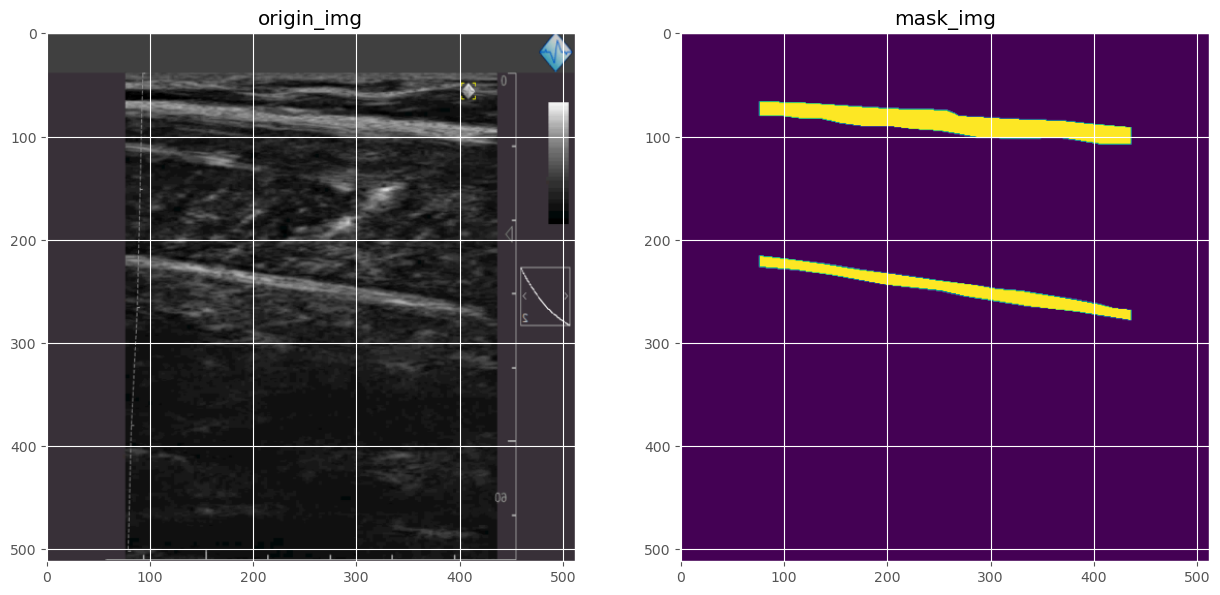

In [10]:
idx = random.randint(0, len(dataset))
orig_img, mask_img = dataset[idx]
print(orig_img.size())

transform = transforms.ToPILImage()
print("showing image of {}: ".format(idx))

orig_img = transform(orig_img)
mask_img = transform(mask_img)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 12))

ax1.imshow(orig_img)
ax1.set_title("origin_img")

ax2.imshow(mask_img)
ax2.set_title("mask_img")

plt.show()

# 训练网络

In [11]:

@torch.inference_mode()
def evaluate(net, dataloader, device, amp):
    net.eval()
    num_val_batches = len(dataloader)
    dice_score = 0
    iou_score = 0

    if isinstance(model, nn.DataParallel):
        n_classes = net.module.n_classes
    else:
        n_classes = net.n_classes
    criterion = nn.CrossEntropyLoss() if n_classes > 1 else nn.BCEWithLogitsLoss()
    dice_loss = smp.losses.DiceLoss(mode='binary', log_loss=True, from_logits = True).cuda()
   
    
    #print("Validation round")
    # iterate over the validation set
    with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
        for batch in tqdm(dataloader, total=num_val_batches, desc='Validation round', unit='batch', position=0 ,leave=True):
            image, mask_true = batch

            # move images and labels to correct device and type
            image = image.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
            mask_true = mask_true.to(device=device, dtype=torch.float32)

            # predict the mask
            mask_pred = net(image)
            dice_score += criterion(mask_pred, mask_true.float())
            dice_score += dice_loss(mask_pred, mask_true)
            
            tp, fp, fn, tn = smp.metrics.get_stats(mask_pred, mask_true.long(), mode='binary', threshold=0.5)
            iou_score += smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
            
    dice_loss = (dice_score / max(num_val_batches, 1))
    iou_score = (iou_score / max(num_val_batches, 1))
    print("Validation dice loss: {}, IoU Score {}".format(dice_loss, iou_score))
    return (dice_loss, iou_score)

In [12]:
import time
import torch.optim as optim
import segmentation_models_pytorch as smp

n_train = len(train_data)
n_val = len(validate_data)


def train(model, device, 
          epochs: int = 60,
          learning_rate: float = 1e-5, 
          weight_decay: float = 1e-8,
          momentum: float = 0.999,
          batch_size: int = 2,
          amp: bool = False,
          val_percent: float = 0.1,
          gradient_clipping: float = 1.0,
          project='U-Net'):
    if isinstance(model, nn.DataParallel):
        n_classes = model.module.n_classes
        n_channels = model.module.n_channels
    else:
        n_classes = model.n_classes
        n_channels = model.n_channels
        
    # (Initialize logging)
    experiment = wandb.init(project=project, resume='allow', anonymous='must')
    experiment.config.update(
        dict(epochs=epochs, batch_size=batch_size, learning_rate=learning_rate,
             val_percent=val_percent, amp=amp)
    )

    logging.info(f'''Starting training:
        Epochs:          {epochs}
        Batch size:      {batch_size}
        Learning rate:   {learning_rate}
        Training size:   {n_train}
        Validation size: {n_val}
        Device:          {device.type}
        Mixed Precision: {amp}
    ''')
    
     # Set up the optimizer, the loss, the learning rate scheduler and the loss scaling for AMP
#     optimizer = optim.RMSprop(model.parameters(),
#                               lr=learning_rate, weight_decay=weight_decay, momentum=momentum, foreach=True)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1, T_mult=2, eta_min=5e-5)  # goal: maximize Dice score
    grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
    criterion = nn.CrossEntropyLoss().cuda()
    dice_loss = smp.losses.DiceLoss(mode='binary')
    
    global_step = 0
    
#     iou_metric = IoU

    # 5. Begin training
    for epoch in range(1, epochs + 1):
        model.train()
        epoch_loss = 0
        with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
            for batch in trainloader:
                images, true_masks = batch

                assert images.shape[1] == n_channels, \
                    f'Network has been defined with {n_channels} input channels, ' \
                    f'but loaded images have {images.shape[1]} channels. Please check that ' \
                    'the images are loaded correctly.'

                images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
                
                true_masks = true_masks.to(device=device, dtype=torch.long)

                with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
                    masks_pred = model(images)
                    loss = criterion(masks_pred, true_masks.float())
                    loss += dice_loss(masks_pred, true_masks)
                    tp, fp, fn, tn = smp.metrics.get_stats(masks_pred, true_masks.long(), mode='binary', threshold=0.5)
                    iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
    
                optimizer.zero_grad(set_to_none=True)
                grad_scaler.scale(loss).backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)
                grad_scaler.step(optimizer)
                grad_scaler.update()

                pbar.update(images.shape[0])
                global_step += 1
                epoch_loss += loss.item()
                experiment.log({
                    'train iou': iou_score,
                    'train loss': loss.item(),
                    'step': global_step,
                    'epoch': epoch
                })
                pbar.set_postfix(**{'loss (batch)': loss.item()})

                # Evaluation round
                division_step = (n_train // (5 * batch_size))
                if division_step > 0:
                    if global_step % division_step == 0:
                        histograms = {}
                        for tag, value in model.named_parameters():
                            tag = tag.replace('/', '.')
                            if not (torch.isinf(value) | torch.isnan(value)).any():
                                histograms['Weights/' + tag] = wandb.Histogram(value.data.cpu())
                            if not value.grad is None:
                                if not (torch.isinf(value.grad) | torch.isnan(value.grad)).any():
                                    histograms['Gradients/' + tag] = wandb.Histogram(value.grad.data.cpu())

                        val_score, iou_score = evaluate(model, valloader, device, amp)
                        model.train()
                        scheduler.step(val_score)

                        logging.info('Validation Dice score: {}'.format(val_score))
                        try:
                            experiment.log({
                                'learning rate': optimizer.param_groups[0]['lr'],
                                'validation Dice': val_score,
                                'validation IoU Score': iou_score,
                                'images': wandb.Image(images[0].cpu()),
                                'masks': {
                                    'true': wandb.Image(true_masks[0].float().cpu()),
                                    'pred': wandb.Image(masks_pred[0].float().cpu()),
                                },
                                'step': global_step,
                                'epoch': epoch,
                                **histograms
                            })
                        except:
                            pass
            

# if __name__ == '__main__':
#     model = UNet(n_channels=3, n_classes=1, bilinear=False)
    
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     if torch.cuda.device_count() > 1:
#         print("Let's use", torch.cuda.device_count(), "GPUs!")
#         model = nn.DataParallel(model)

#     model = model.to(memory_format=torch.channels_last)
#     model.to(device)
    
#     train(model, device)

    

In [13]:
model = UNet(n_channels=3, n_classes=1, n_filters = 64)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)

model = model.to(memory_format=torch.channels_last)
model.to(device)


total_params = sum(p.numel() for p in model.parameters())
print(f"UNet-ScConv模型参数量为：{total_params}")
print("其详情为：")
for name,parameters in model.named_parameters():
    print(name,':',parameters.size())

train(model, device, project='UNet-ScConv')

n_channels:  64 n_groups:  2
out_channels: 128 squeeze_radio:  2 up_channel:  32 in_ch (out_channels // squeeze_radio):  16 out_ch(out_channels): 128
in_channels:  64 out_channels:  128
up_channel:  32 low_channel:  32
out_channels: 128 squeeze_radio:  2 low_channel:  32 in_ch (low_channel // squeeze_radio):  16 out_ch(out_channels - low_channel // squeeze_radio): 112
n_channels:  128 n_groups:  2
out_channels: 128 squeeze_radio:  2 up_channel:  64 in_ch (out_channels // squeeze_radio):  32 out_ch(out_channels): 128
in_channels:  128 out_channels:  128
up_channel:  64 low_channel:  64
out_channels: 128 squeeze_radio:  2 low_channel:  64 in_ch (low_channel // squeeze_radio):  32 out_ch(out_channels - low_channel // squeeze_radio): 96
in_channels:  64 out_channels:  128
n_channels:  128 n_groups:  2
out_channels: 256 squeeze_radio:  2 up_channel:  64 in_ch (out_channels // squeeze_radio):  32 out_ch(out_channels): 256
in_channels:  128 out_channels:  256
up_channel:  64 low_channel:  64


wandb: Currently logged in as: torwayland (cupes-wangtao). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.16.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.15.5
wandb: Run data is saved locally in /kaggle/working/wandb/run-20231221_075635-nqovsdyn
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run proud-violet-14
wandb: ⭐️ View project at https://wandb.ai/cupes-wangtao/UNet-ScConv
wandb: 🚀 View run at https://wandb.ai/cupes-wangtao/UNet-ScConv/runs/nqovsdyn
Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.21batch/s]


Validation dice loss: 3.482184648513794, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.14batch/s]


Validation dice loss: 3.395642042160034, IoU Score 0.044379543513059616


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.21batch/s]


Validation dice loss: 3.1396031379699707, IoU Score 0.30582955479621887


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.22batch/s]


Validation dice loss: 3.1013779640197754, IoU Score 0.301627516746521


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.24batch/s]


Validation dice loss: 3.0820887088775635, IoU Score 0.29819557070732117


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.21batch/s]


Validation dice loss: 3.071916341781616, IoU Score 0.28585654497146606


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.18batch/s]


Validation dice loss: 3.050760507583618, IoU Score 0.3012171983718872


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.24batch/s]


Validation dice loss: 3.0089268684387207, IoU Score 0.2624601721763611


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.25batch/s]


Validation dice loss: 3.0216636657714844, IoU Score 0.2779783010482788


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.25batch/s]


Validation dice loss: 2.9786267280578613, IoU Score 0.2692224085330963


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.25batch/s]


Validation dice loss: 2.922057867050171, IoU Score 0.24202953279018402


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.21batch/s]


Validation dice loss: 2.854497194290161, IoU Score 0.24341949820518494


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.26batch/s]


Validation dice loss: 2.7248690128326416, IoU Score 0.2609477937221527


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.24batch/s]


Validation dice loss: 2.6782162189483643, IoU Score 0.2568516731262207


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.24batch/s]


Validation dice loss: 2.6705548763275146, IoU Score 0.2286236584186554


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.23batch/s]


Validation dice loss: 2.5892813205718994, IoU Score 0.24546237289905548


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.21batch/s]


Validation dice loss: 2.5808255672454834, IoU Score 0.2362755835056305


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.25batch/s]


Validation dice loss: 2.547135829925537, IoU Score 0.2396298497915268


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.26batch/s]


Validation dice loss: 2.4215266704559326, IoU Score 0.2539912164211273


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.24batch/s]


Validation dice loss: 2.3445866107940674, IoU Score 0.2538589537143707


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.24batch/s]


Validation dice loss: 2.324899435043335, IoU Score 0.2594648599624634


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.20batch/s]


Validation dice loss: 2.2911911010742188, IoU Score 0.2616690397262573


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.24batch/s]


Validation dice loss: 2.2424232959747314, IoU Score 0.2549901008605957


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.22batch/s]


Validation dice loss: 2.1841139793395996, IoU Score 0.26901736855506897


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.24batch/s]


Validation dice loss: 2.2033801078796387, IoU Score 0.26765796542167664


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.20batch/s]


Validation dice loss: 2.095980167388916, IoU Score 0.27414414286613464


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.18batch/s]


Validation dice loss: 2.0149545669555664, IoU Score 0.3074221909046173


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.18batch/s]


Validation dice loss: 2.014988899230957, IoU Score 0.2851187288761139


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.20batch/s]


Validation dice loss: 2.0259997844696045, IoU Score 0.2952723205089569


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.21batch/s]


Validation dice loss: 2.060969114303589, IoU Score 0.30126556754112244


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.22batch/s]


Validation dice loss: 1.8782693147659302, IoU Score 0.3160395622253418


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.17batch/s]


Validation dice loss: 1.8183680772781372, IoU Score 0.33702167868614197


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.21batch/s]


Validation dice loss: 1.947593092918396, IoU Score 0.31962719559669495


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.21batch/s]


Validation dice loss: 1.739696741104126, IoU Score 0.34849098324775696


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.21batch/s]


Validation dice loss: 1.8519364595413208, IoU Score 0.31969380378723145


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.19batch/s]


Validation dice loss: 1.7152705192565918, IoU Score 0.34660810232162476


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.14batch/s]


Validation dice loss: 1.7662127017974854, IoU Score 0.33053287863731384


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.19batch/s]


Validation dice loss: 1.6167106628417969, IoU Score 0.35340172052383423


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.20batch/s]


Validation dice loss: 1.6720657348632812, IoU Score 0.33965927362442017


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.21batch/s]


Validation dice loss: 1.7253189086914062, IoU Score 0.3382217288017273


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.22batch/s]


Validation dice loss: 1.6258549690246582, IoU Score 0.38116180896759033


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.17batch/s]


Validation dice loss: 1.6069971323013306, IoU Score 0.3566000163555145


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.22batch/s]


Validation dice loss: 1.6193506717681885, IoU Score 0.37889546155929565


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.20batch/s]


Validation dice loss: 1.5542455911636353, IoU Score 0.3603612184524536


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.21batch/s]


Validation dice loss: 1.5707262754440308, IoU Score 0.3524879217147827


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.20batch/s]


Validation dice loss: 1.613951325416565, IoU Score 0.36269402503967285


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.15batch/s]


Validation dice loss: 1.5002293586730957, IoU Score 0.3671548068523407


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.16batch/s]


Validation dice loss: 1.5062451362609863, IoU Score 0.3673717975616455


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.19batch/s]


Validation dice loss: 1.5654172897338867, IoU Score 0.3602044880390167


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.27batch/s]


Validation dice loss: 1.481806755065918, IoU Score 0.37004104256629944


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.23batch/s]


Validation dice loss: 1.395862102508545, IoU Score 0.3896852433681488


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.16batch/s]


Validation dice loss: 1.4224573373794556, IoU Score 0.39194127917289734


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.22batch/s]


Validation dice loss: 1.3418971300125122, IoU Score 0.3844412863254547


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.21batch/s]


Validation dice loss: 1.3862611055374146, IoU Score 0.3900178074836731


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.23batch/s]


Validation dice loss: 1.3923368453979492, IoU Score 0.37344998121261597


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.24batch/s]


Validation dice loss: 1.3510246276855469, IoU Score 0.39966118335723877


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.20batch/s]


Validation dice loss: 1.3663196563720703, IoU Score 0.3936757445335388


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.25batch/s]


Validation dice loss: 1.3085722923278809, IoU Score 0.41925114393234253


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.25batch/s]


Validation dice loss: 1.3271359205245972, IoU Score 0.39792072772979736


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.25batch/s]


Validation dice loss: 1.2469429969787598, IoU Score 0.4283502399921417


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.24batch/s]


Validation dice loss: 1.2598655223846436, IoU Score 0.4226320683956146


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.19batch/s]


Validation dice loss: 1.277414321899414, IoU Score 0.4024152159690857


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.23batch/s]


Validation dice loss: 1.2617149353027344, IoU Score 0.4300955533981323


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.22batch/s]


Validation dice loss: 1.2733891010284424, IoU Score 0.4138202369213104


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.22batch/s]


Validation dice loss: 1.2482372522354126, IoU Score 0.4168388843536377


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.24batch/s]


Validation dice loss: 1.193285584449768, IoU Score 0.4271382987499237


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.24batch/s]


Validation dice loss: 1.1728407144546509, IoU Score 0.4452116787433624


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.21batch/s]


Validation dice loss: 1.1983757019042969, IoU Score 0.4296225905418396


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.16batch/s]


Validation dice loss: 1.1999669075012207, IoU Score 0.45456573367118835


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.19batch/s]


Validation dice loss: 1.1814000606536865, IoU Score 0.4442387521266937


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.21batch/s]


Validation dice loss: 1.1423072814941406, IoU Score 0.4532111585140228


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.24batch/s]


Validation dice loss: 1.1486992835998535, IoU Score 0.45398375391960144


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.23batch/s]


Validation dice loss: 1.1316801309585571, IoU Score 0.45746782422065735


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.21batch/s]


Validation dice loss: 1.1286485195159912, IoU Score 0.4636880159378052


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.24batch/s]


Validation dice loss: 1.1195974349975586, IoU Score 0.4550441801548004


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.23batch/s]


Validation dice loss: 1.160341501235962, IoU Score 0.466595858335495


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.23batch/s]


Validation dice loss: 1.0885367393493652, IoU Score 0.462952196598053


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.22batch/s]


Validation dice loss: 1.1031173467636108, IoU Score 0.4656609296798706


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.24batch/s]


Validation dice loss: 1.073625922203064, IoU Score 0.46624988317489624


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.24batch/s]


Validation dice loss: 1.0991774797439575, IoU Score 0.46529632806777954


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.23batch/s]


Validation dice loss: 1.0766240358352661, IoU Score 0.46309587359428406


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.18batch/s]


Validation dice loss: 1.0505671501159668, IoU Score 0.46701475977897644


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.17batch/s]


Validation dice loss: 1.1162517070770264, IoU Score 0.47003158926963806


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.20batch/s]


Validation dice loss: 1.0884286165237427, IoU Score 0.4763035476207733


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.19batch/s]


Validation dice loss: 1.0114871263504028, IoU Score 0.4842621088027954


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.15batch/s]


Validation dice loss: 1.0791821479797363, IoU Score 0.47730153799057007


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.19batch/s]


Validation dice loss: 1.0548561811447144, IoU Score 0.48394596576690674


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.19batch/s]


Validation dice loss: 1.030046820640564, IoU Score 0.47870832681655884


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.19batch/s]


Validation dice loss: 1.0248419046401978, IoU Score 0.4919513761997223


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.19batch/s]


Validation dice loss: 1.023416519165039, IoU Score 0.48451846837997437


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.20batch/s]


Validation dice loss: 0.978287398815155, IoU Score 0.49155715107917786


Epoch 18/60:  99%|█████████▉| 452/456 [07:03<00:04,  1.08s/img, loss (batch)=0.491]wandb: Network error (ReadTimeout), entering retry loop.
wandb: Network error (ReadTimeout), entering retry loop.
wandb: Network error (ReadTimeout), entering retry loop.
wandb: Network error (ReadTimeout), entering retry loop.
wandb: Network error (ReadTimeout), entering retry loop.
Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.20batch/s]


Validation dice loss: 0.9914577007293701, IoU Score 0.49383026361465454


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.18batch/s]


Validation dice loss: 0.9878460168838501, IoU Score 0.4854147732257843


Epoch 19/60:  39%|███▊      | 176/456 [02:46<05:05,  1.09s/img, loss (batch)=0.617]wandb: Network error (ReadTimeout), entering retry loop.
wandb: Network error (ReadTimeout), entering retry loop.
wandb: Network error (ReadTimeout), entering retry loop.
wandb: Network error (ReadTimeout), entering retry loop.
Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.20batch/s]


Validation dice loss: 1.109827995300293, IoU Score 0.4255305826663971


Epoch 19/60:  58%|█████▊    | 266/456 [04:10<03:26,  1.09s/img, loss (batch)=0.514]wandb: Network error (ReadTimeout), entering retry loop.
wandb: Network error (ReadTimeout), entering retry loop.
wandb: Network error (ReadTimeout), entering retry loop.
Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.19batch/s]


Validation dice loss: 0.98133385181427, IoU Score 0.5088827610015869


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.19batch/s]


Validation dice loss: 0.8785313367843628, IoU Score 0.48806536197662354


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.20batch/s]


Validation dice loss: 0.9258245825767517, IoU Score 0.5065787434577942


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.20batch/s]


Validation dice loss: 0.8933254480361938, IoU Score 0.5165405869483948


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.21batch/s]


Validation dice loss: 0.8437716960906982, IoU Score 0.5001993775367737


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.20batch/s]


Validation dice loss: 0.8348462581634521, IoU Score 0.5218749642372131


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.16batch/s]


Validation dice loss: 0.7958152294158936, IoU Score 0.5288357734680176


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.21batch/s]


Validation dice loss: 0.7907336354255676, IoU Score 0.5257584452629089


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.22batch/s]


Validation dice loss: 0.8155817985534668, IoU Score 0.5266051292419434


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.20batch/s]


Validation dice loss: 0.778171956539154, IoU Score 0.5177289843559265


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.18batch/s]


Validation dice loss: 0.8808701038360596, IoU Score 0.5079363584518433


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.16batch/s]


Validation dice loss: 0.7746729850769043, IoU Score 0.5291405916213989


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.20batch/s]


Validation dice loss: 0.7857028841972351, IoU Score 0.5332406163215637


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.19batch/s]


Validation dice loss: 0.7422196269035339, IoU Score 0.5365014672279358


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.17batch/s]


Validation dice loss: 0.7091320157051086, IoU Score 0.5388737916946411


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.18batch/s]


Validation dice loss: 0.7151497006416321, IoU Score 0.5276244282722473


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.17batch/s]


Validation dice loss: 0.6804537177085876, IoU Score 0.5463263392448425


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.17batch/s]


Validation dice loss: 0.6904230713844299, IoU Score 0.5210365653038025


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.24batch/s]


Validation dice loss: 0.6994189620018005, IoU Score 0.5508564114570618


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.23batch/s]


Validation dice loss: 0.7068396806716919, IoU Score 0.5397676825523376


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.22batch/s]


Validation dice loss: 0.6657412648200989, IoU Score 0.5450183153152466


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.20batch/s]


Validation dice loss: 0.6841006875038147, IoU Score 0.5472044944763184


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.21batch/s]


Validation dice loss: 0.8335338830947876, IoU Score 0.48904603719711304


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.24batch/s]


Validation dice loss: 0.6952958106994629, IoU Score 0.5381759405136108


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.25batch/s]


Validation dice loss: 0.6676457524299622, IoU Score 0.5500362515449524


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.24batch/s]


Validation dice loss: 0.6494768857955933, IoU Score 0.5636987090110779


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.21batch/s]


Validation dice loss: 0.6608109474182129, IoU Score 0.5475330352783203


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.26batch/s]


Validation dice loss: 0.6477510929107666, IoU Score 0.5555020570755005


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.20batch/s]


Validation dice loss: 0.7198947072029114, IoU Score 0.5238884091377258


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.24batch/s]


Validation dice loss: 0.6797783374786377, IoU Score 0.547382652759552


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.25batch/s]


Validation dice loss: 0.6512355804443359, IoU Score 0.5512458086013794


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.21batch/s]


Validation dice loss: 0.6414428949356079, IoU Score 0.5498567819595337


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.23batch/s]


Validation dice loss: 0.6752045154571533, IoU Score 0.5454510450363159


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.25batch/s]


Validation dice loss: 0.6201091408729553, IoU Score 0.5666581988334656


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.25batch/s]


Validation dice loss: 0.6465586423873901, IoU Score 0.5356782674789429


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.21batch/s]


Validation dice loss: 0.6326687335968018, IoU Score 0.5663189888000488


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.21batch/s]


Validation dice loss: 0.6286627650260925, IoU Score 0.5590416789054871


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.25batch/s]


Validation dice loss: 0.6350961327552795, IoU Score 0.5621298551559448


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.24batch/s]


Validation dice loss: 0.5983041524887085, IoU Score 0.5733363628387451


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.23batch/s]


Validation dice loss: 0.593843400478363, IoU Score 0.5762407183647156


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.21batch/s]


Validation dice loss: 0.6366990208625793, IoU Score 0.5625189542770386


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.13batch/s]


Validation dice loss: 0.5984418392181396, IoU Score 0.5638607740402222


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.21batch/s]


Validation dice loss: 0.5880143642425537, IoU Score 0.5674232840538025


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.21batch/s]


Validation dice loss: 0.6974976658821106, IoU Score 0.5253005623817444


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.21batch/s]


Validation dice loss: 0.5399447679519653, IoU Score 0.5756020545959473


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.22batch/s]


Validation dice loss: 0.5979261994361877, IoU Score 0.5639282464981079


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.13batch/s]


Validation dice loss: 0.5955891609191895, IoU Score 0.5674813985824585


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.14batch/s]


Validation dice loss: 0.6074442863464355, IoU Score 0.5708070993423462


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.19batch/s]


Validation dice loss: 0.6523956656455994, IoU Score 0.5484946966171265


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.20batch/s]


Validation dice loss: 0.6636160016059875, IoU Score 0.5486351251602173


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.15batch/s]


Validation dice loss: 0.5799978971481323, IoU Score 0.5792556405067444


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.13batch/s]


Validation dice loss: 0.5713559985160828, IoU Score 0.5805312991142273


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.17batch/s]


Validation dice loss: 0.6677889227867126, IoU Score 0.5422236919403076


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.17batch/s]


Validation dice loss: 0.6249204874038696, IoU Score 0.570529043674469


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.22batch/s]


Validation dice loss: 0.5859332084655762, IoU Score 0.573147714138031


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.27batch/s]


Validation dice loss: 0.574877917766571, IoU Score 0.5580861568450928


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.15batch/s]


Validation dice loss: 0.7173793911933899, IoU Score 0.5114567875862122


Epoch 30/60: 100%|██████████| 456/456 [07:28<00:00,  1.02img/s, loss (batch)=0.716]


Validation dice loss: 0.5991865396499634, IoU Score 0.5741198062896729


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.19batch/s]


Validation dice loss: 0.6483575105667114, IoU Score 0.5448931455612183


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.19batch/s]


Validation dice loss: 0.5777983069419861, IoU Score 0.5785853266716003


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.19batch/s]


Validation dice loss: 0.6073880195617676, IoU Score 0.560084879398346


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.15batch/s]


Validation dice loss: 0.5041639804840088, IoU Score 0.5945441126823425


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.25batch/s]


Validation dice loss: 0.5741989612579346, IoU Score 0.5734754204750061


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.25batch/s]


Validation dice loss: 0.5318245887756348, IoU Score 0.5913038849830627


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.22batch/s]


Validation dice loss: 0.5916094183921814, IoU Score 0.5771548748016357


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.20batch/s]


Validation dice loss: 0.5961377024650574, IoU Score 0.5750188231468201


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.22batch/s]


Validation dice loss: 0.5933271646499634, IoU Score 0.5785424113273621


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.24batch/s]


Validation dice loss: 0.5704966187477112, IoU Score 0.5501059889793396


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.25batch/s]


Validation dice loss: 0.6117634177207947, IoU Score 0.567107617855072


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.25batch/s]


Validation dice loss: 0.5324123501777649, IoU Score 0.5865845084190369


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.26batch/s]


Validation dice loss: 0.48735350370407104, IoU Score 0.5986549258232117


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.22batch/s]


Validation dice loss: 0.6196865439414978, IoU Score 0.5563669204711914


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.20batch/s]


Validation dice loss: 0.544574499130249, IoU Score 0.5815303325653076


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.25batch/s]


Validation dice loss: 0.5886639356613159, IoU Score 0.5866855978965759


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.19batch/s]


Validation dice loss: 0.5727742314338684, IoU Score 0.5796117186546326


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.21batch/s]


Validation dice loss: 0.596738874912262, IoU Score 0.5724833607673645


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.20batch/s]


Validation dice loss: 0.55329430103302, IoU Score 0.5941388010978699


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.20batch/s]


Validation dice loss: 0.572803258895874, IoU Score 0.58404541015625


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.21batch/s]


Validation dice loss: 0.6000285744667053, IoU Score 0.5759780406951904


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.22batch/s]


Validation dice loss: 0.5486046671867371, IoU Score 0.58649742603302


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.20batch/s]


Validation dice loss: 0.5627365708351135, IoU Score 0.5840796828269958


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.17batch/s]


Validation dice loss: 0.5281237959861755, IoU Score 0.5944139957427979


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.20batch/s]


Validation dice loss: 0.5591639280319214, IoU Score 0.5868458151817322


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.17batch/s]


Validation dice loss: 0.5216968059539795, IoU Score 0.5701079368591309


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.17batch/s]


Validation dice loss: 0.591148853302002, IoU Score 0.5767356753349304


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.24batch/s]


Validation dice loss: 0.588434100151062, IoU Score 0.5786283016204834


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.23batch/s]


Validation dice loss: 0.6096386313438416, IoU Score 0.5708813667297363


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.22batch/s]


Validation dice loss: 0.5076407194137573, IoU Score 0.593070387840271


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.22batch/s]


Validation dice loss: 0.6179506778717041, IoU Score 0.5648550391197205


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.20batch/s]


Validation dice loss: 0.4869000315666199, IoU Score 0.6047670245170593


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.22batch/s]


Validation dice loss: 0.5115423798561096, IoU Score 0.6037236452102661


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.21batch/s]


Validation dice loss: 0.4798406958580017, IoU Score 0.6017519235610962


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.24batch/s]


Validation dice loss: 0.5009052753448486, IoU Score 0.5730525255203247


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.23batch/s]


Validation dice loss: 0.529043436050415, IoU Score 0.5939085483551025


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.20batch/s]


Validation dice loss: 0.5725773572921753, IoU Score 0.5922146439552307


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.24batch/s]


Validation dice loss: 0.5954691171646118, IoU Score 0.5761145353317261


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.22batch/s]


Validation dice loss: 0.5944103598594666, IoU Score 0.5780795812606812


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.22batch/s]


Validation dice loss: 0.4725259244441986, IoU Score 0.6061075925827026


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.23batch/s]


Validation dice loss: 0.619377851486206, IoU Score 0.5641663670539856


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.24batch/s]


Validation dice loss: 0.5348057746887207, IoU Score 0.6075193881988525


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.19batch/s]


Validation dice loss: 0.46976834535598755, IoU Score 0.6084331274032593


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.24batch/s]


Validation dice loss: 0.5536355376243591, IoU Score 0.5994583964347839


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.23batch/s]


Validation dice loss: 0.575355589389801, IoU Score 0.5693224668502808


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.22batch/s]


Validation dice loss: 0.5304762721061707, IoU Score 0.6033188700675964


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.23batch/s]


Validation dice loss: 0.5171318054199219, IoU Score 0.5925366878509521


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.16batch/s]


Validation dice loss: 0.4524960219860077, IoU Score 0.6121957302093506


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.21batch/s]


Validation dice loss: 0.5402687191963196, IoU Score 0.6044818162918091


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.22batch/s]


Validation dice loss: 0.5632838606834412, IoU Score 0.5977452397346497


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.22batch/s]


Validation dice loss: 0.5462284088134766, IoU Score 0.5977322459220886


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.23batch/s]


Validation dice loss: 0.47739553451538086, IoU Score 0.6069682836532593


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.14batch/s]


Validation dice loss: 0.5907508730888367, IoU Score 0.5819351077079773


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.22batch/s]


Validation dice loss: 0.5141472816467285, IoU Score 0.6091071367263794


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.25batch/s]


Validation dice loss: 0.5101052522659302, IoU Score 0.5893405079841614


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.24batch/s]


Validation dice loss: 0.44770488142967224, IoU Score 0.6169473528862


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.23batch/s]


Validation dice loss: 0.46249645948410034, IoU Score 0.6151092648506165


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.19batch/s]


Validation dice loss: 0.4783024191856384, IoU Score 0.6070850491523743


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.26batch/s]


Validation dice loss: 0.5068939924240112, IoU Score 0.5965535640716553


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.23batch/s]


Validation dice loss: 0.4641982614994049, IoU Score 0.6118143796920776


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.21batch/s]


Validation dice loss: 0.4695974290370941, IoU Score 0.61058109998703


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.25batch/s]


Validation dice loss: 0.4724756181240082, IoU Score 0.6106518507003784


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.20batch/s]


Validation dice loss: 0.5549321174621582, IoU Score 0.5983061194419861


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.25batch/s]


Validation dice loss: 0.49805742502212524, IoU Score 0.6063345074653625


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.26batch/s]


Validation dice loss: 0.4607506990432739, IoU Score 0.6068345308303833


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.26batch/s]


Validation dice loss: 0.48576149344444275, IoU Score 0.6012172698974609


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.22batch/s]


Validation dice loss: 0.6398875117301941, IoU Score 0.5606526732444763


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.20batch/s]


Validation dice loss: 0.46236056089401245, IoU Score 0.6102137565612793


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.22batch/s]


Validation dice loss: 0.4695853590965271, IoU Score 0.6059218049049377


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.23batch/s]


Validation dice loss: 0.47812747955322266, IoU Score 0.5946952104568481


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.23batch/s]


Validation dice loss: 0.45858705043792725, IoU Score 0.6162330508232117


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.22batch/s]


Validation dice loss: 0.46581560373306274, IoU Score 0.6054580211639404


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.21batch/s]


Validation dice loss: 0.5757946968078613, IoU Score 0.6017563343048096


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.25batch/s]


Validation dice loss: 0.45735737681388855, IoU Score 0.6157548427581787


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.26batch/s]


Validation dice loss: 0.4442923665046692, IoU Score 0.6227507591247559


Epoch 45/60: 100%|██████████| 456/456 [07:27<00:00,  1.02img/s, loss (batch)=0.188]


Validation dice loss: 0.5398504734039307, IoU Score 0.5957769751548767


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.22batch/s]


Validation dice loss: 0.45289772748947144, IoU Score 0.6205399632453918


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.16batch/s]


Validation dice loss: 0.5420740246772766, IoU Score 0.6075848340988159


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.21batch/s]


Validation dice loss: 0.5221902132034302, IoU Score 0.6120283603668213


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.25batch/s]


Validation dice loss: 0.4479636549949646, IoU Score 0.6215886473655701


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.23batch/s]


Validation dice loss: 0.44896724820137024, IoU Score 0.6244986653327942


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.25batch/s]


Validation dice loss: 0.44821402430534363, IoU Score 0.6226053833961487


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.20batch/s]


Validation dice loss: 0.5279338359832764, IoU Score 0.6059608459472656


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.25batch/s]


Validation dice loss: 0.4615453779697418, IoU Score 0.6164554357528687


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.23batch/s]


Validation dice loss: 0.5415619015693665, IoU Score 0.5859804153442383


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.23batch/s]


Validation dice loss: 0.45965975522994995, IoU Score 0.6191591620445251


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.23batch/s]


Validation dice loss: 0.44852709770202637, IoU Score 0.6243776679039001


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.17batch/s]


Validation dice loss: 0.4742545783519745, IoU Score 0.6248076558113098


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.27batch/s]


Validation dice loss: 0.4340200126171112, IoU Score 0.6236129403114319


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.22batch/s]


Validation dice loss: 0.5078451633453369, IoU Score 0.6001519560813904


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.23batch/s]


Validation dice loss: 0.5839149951934814, IoU Score 0.5833873152732849


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.23batch/s]


Validation dice loss: 0.4727189540863037, IoU Score 0.6201753616333008


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.13batch/s]


Validation dice loss: 0.5381424427032471, IoU Score 0.6084184050559998


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.24batch/s]


Validation dice loss: 0.48004141449928284, IoU Score 0.6125460267066956


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.22batch/s]


Validation dice loss: 0.6239040493965149, IoU Score 0.5860496759414673


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.23batch/s]


Validation dice loss: 0.49552789330482483, IoU Score 0.6154417395591736


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.22batch/s]


Validation dice loss: 0.6705676317214966, IoU Score 0.5566257238388062


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.17batch/s]


Validation dice loss: 0.43962907791137695, IoU Score 0.6278638243675232


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.23batch/s]


Validation dice loss: 0.44755062460899353, IoU Score 0.6253041625022888


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.23batch/s]


Validation dice loss: 0.4502534866333008, IoU Score 0.6238582730293274


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.23batch/s]


Validation dice loss: 0.5205502510070801, IoU Score 0.6222066283226013


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.22batch/s]


Validation dice loss: 0.4361876845359802, IoU Score 0.6248937845230103


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.18batch/s]


Validation dice loss: 0.5417674779891968, IoU Score 0.5889263153076172


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.21batch/s]


Validation dice loss: 0.4373303949832916, IoU Score 0.6272934079170227


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.21batch/s]


Validation dice loss: 0.4396112263202667, IoU Score 0.6287345290184021


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.22batch/s]


Validation dice loss: 0.4729088246822357, IoU Score 0.6144382953643799


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.23batch/s]


Validation dice loss: 0.4644595682621002, IoU Score 0.6167196035385132


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.25batch/s]


Validation dice loss: 0.5083092451095581, IoU Score 0.5992780327796936


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.20batch/s]


Validation dice loss: 0.4317103922367096, IoU Score 0.6286213397979736


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.20batch/s]


Validation dice loss: 0.4276934564113617, IoU Score 0.632107138633728


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.21batch/s]


Validation dice loss: 0.6789150238037109, IoU Score 0.5442325472831726


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.21batch/s]


Validation dice loss: 0.5903851985931396, IoU Score 0.5764721035957336


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.22batch/s]


Validation dice loss: 0.42384010553359985, IoU Score 0.6351681351661682


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.18batch/s]


Validation dice loss: 0.49190691113471985, IoU Score 0.5980172753334045


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.19batch/s]


Validation dice loss: 0.46422332525253296, IoU Score 0.6127532720565796


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.22batch/s]


Validation dice loss: 0.4186871349811554, IoU Score 0.6382881999015808


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.18batch/s]


Validation dice loss: 0.43067529797554016, IoU Score 0.6327458024024963


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.21batch/s]


Validation dice loss: 0.46288540959358215, IoU Score 0.6194734573364258


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.22batch/s]


Validation dice loss: 0.43530580401420593, IoU Score 0.6341022253036499


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.24batch/s]


Validation dice loss: 0.43271276354789734, IoU Score 0.6337701082229614


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.21batch/s]


Validation dice loss: 0.4507480561733246, IoU Score 0.6286201477050781


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.20batch/s]


Validation dice loss: 0.4524083137512207, IoU Score 0.6254280209541321


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.21batch/s]


Validation dice loss: 0.4737793207168579, IoU Score 0.6222928762435913


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.21batch/s]


Validation dice loss: 0.42047733068466187, IoU Score 0.637624979019165


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.21batch/s]


Validation dice loss: 0.43499866127967834, IoU Score 0.6309419870376587


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.23batch/s]


Validation dice loss: 0.44551292061805725, IoU Score 0.6296519637107849


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.21batch/s]


Validation dice loss: 0.43548136949539185, IoU Score 0.6300625801086426


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.21batch/s]


Validation dice loss: 0.4450801610946655, IoU Score 0.6277755498886108


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.17batch/s]


Validation dice loss: 0.5254249572753906, IoU Score 0.6141466498374939


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.19batch/s]


Validation dice loss: 0.4470558166503906, IoU Score 0.628991961479187


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.23batch/s]


Validation dice loss: 0.4483789801597595, IoU Score 0.6263185739517212


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.19batch/s]


Validation dice loss: 0.44195419549942017, IoU Score 0.6298044919967651


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.15batch/s]


Validation dice loss: 0.45539531111717224, IoU Score 0.6260693073272705


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.21batch/s]


Validation dice loss: 0.4595067501068115, IoU Score 0.618410587310791


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.21batch/s]


Validation dice loss: 0.5099087357521057, IoU Score 0.5995463728904724


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.21batch/s]


Validation dice loss: 0.4248323440551758, IoU Score 0.6320379972457886


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.18batch/s]


Validation dice loss: 0.4224995970726013, IoU Score 0.6414308547973633


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.21batch/s]


Validation dice loss: 0.42514458298683167, IoU Score 0.6381963491439819


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.23batch/s]


Validation dice loss: 0.4195983111858368, IoU Score 0.6401453614234924


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.21batch/s]


Validation dice loss: 0.42215439677238464, IoU Score 0.6367970108985901


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.23batch/s]


Validation dice loss: 0.42799898982048035, IoU Score 0.6364257335662842


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.20batch/s]


Validation dice loss: 0.44557300209999084, IoU Score 0.6320551037788391


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.23batch/s]


Validation dice loss: 0.43609169125556946, IoU Score 0.6337159872055054


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.21batch/s]


Validation dice loss: 0.41508710384368896, IoU Score 0.6430390477180481


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.23batch/s]


Validation dice loss: 0.43477094173431396, IoU Score 0.6294744610786438


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.21batch/s]


Validation dice loss: 0.44043025374412537, IoU Score 0.6343370676040649


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.16batch/s]


Validation dice loss: 0.4657457172870636, IoU Score 0.6260687112808228


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.22batch/s]


Validation dice loss: 0.46149396896362305, IoU Score 0.6277364492416382


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.21batch/s]


Validation dice loss: 0.43342021107673645, IoU Score 0.6381435990333557


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.19batch/s]


Validation dice loss: 0.44301438331604004, IoU Score 0.6333407759666443


Validation round: 100%|██████████| 115/115 [00:21<00:00,  5.23batch/s]


Validation dice loss: 0.4139502942562103, IoU Score 0.6458768844604492


Validation round: 100%|██████████| 115/115 [00:22<00:00,  5.17batch/s]


Validation dice loss: 0.4227665662765503, IoU Score 0.6334819197654724


Epoch 60/60: 100%|██████████| 456/456 [07:28<00:00,  1.02img/s, loss (batch)=0.34]


# 推理